# Google Colab Setup

In [3]:
#@title Setup Google Colab by running this cell only once (ignore this if run locally) {display-mode: "form"}
import sys 
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/epfl-exts/aml24-master-class.git
        
    # Copy files required to run the code
    !cp -r "aml24-master-class/text_classification/data" "aml24-master-class/text_classification/tools.py" .
    
    # Install packages via pip
    !pip install -r "aml24-master-class/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

## Spam Detection based on Text Embeddings

### Task

We continue with the task of building a spam detector but using the text embeddings this time. Embeddings are vector representations of text data and are designed to capture the semantic meaning and context of the words or sentences they represent. 

### Data

The dataset has been downloaded for you and is available in the *data* folder.

### Notebook overview

* Load and prepare the data
* Quick analysis of the data
* PCA on embeddings
* Build a spam detector

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

## Load and prepare the data

Load the 'email_embeddings.csv' dataset from the data folder. The dataset contains an embedding vector for each email. Each vector is a numerical representation of an email as a whole, and captures its semantic meaning. We use embeddings obtained using the *Gecko* model which can produce 768 dimensional embeddings for English texts.

Let's load the 'email_embeddings.csv' data, check its shape and a few rows of it.

In [3]:
# load email_embeddings.csv file

df = pd.read_csv('data/email_embeddings.csv')

# check the shape of data and a few rows of it
print(df.shape)
df.head()

(5832, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.012373,-0.018983,-0.015448,0.017502,0.035560,-0.000460,0.033559,-0.013540,-0.019357,0.043482,...,-0.023635,0.044551,0.022994,0.029587,0.011559,-0.008164,-0.017245,-0.009922,-0.034954,-0.039636
1,-0.000592,-0.036461,-0.025587,0.017729,0.031857,-0.045625,0.051302,0.025131,-0.002957,0.040964,...,-0.018732,0.036356,0.004606,0.048945,-0.039095,0.036534,-0.025406,-0.004709,-0.006947,-0.029345
2,-0.015628,-0.032974,-0.017868,0.030587,0.015972,-0.012683,0.016617,-0.008228,-0.026466,0.017005,...,0.020764,0.034141,-0.034710,0.015784,-0.043653,0.021216,0.010660,-0.027863,-0.005670,-0.029882
3,0.033675,-0.025316,-0.006813,0.028282,0.037449,-0.038211,0.043962,0.011977,-0.022668,0.003135,...,0.004263,0.023893,-0.004593,0.034003,-0.013506,0.049029,-0.014022,0.014270,-0.017976,-0.014652
4,0.001591,-0.035304,0.008094,0.017116,0.026043,-0.008375,0.017645,-0.000340,-0.005837,0.022499,...,-0.029826,0.022401,-0.018729,0.050755,-0.040724,0.009831,-0.022889,-0.026048,-0.012297,-0.013357


### 💡 Observations

As expected, the data has 5832 rows corresponding to the emails, and 768 columns of embeddings.

Let's load the 'email_text.csv' data and add its 'label' and 'text' columns to the embedding datframe.

In [4]:
# load email_text.csv file

df_text = pd.read_csv('data/email_text.csv')

# add the text and label columns to the new dataframe
df['label'] = df_text.label
df['text'] = df_text.text

print(df.shape)
df.head()

(5832, 770)


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,label,text
0,-0.012373,-0.018983,-0.015448,0.017502,0.035560,-0.000460,0.033559,-0.013540,-0.019357,0.043482,...,0.022994,0.029587,0.011559,-0.008164,-0.017245,-0.009922,-0.034954,-0.039636,1,"Dear Homeowner,\n \nInterest Rates are at thei..."
1,-0.000592,-0.036461,-0.025587,0.017729,0.031857,-0.045625,0.051302,0.025131,-0.002957,0.040964,...,0.004606,0.048945,-0.039095,0.036534,-0.025406,-0.004709,-0.006947,-0.029345,1,ATTENTION: This is a MUST for ALL Computer Use...
2,-0.015628,-0.032974,-0.017868,0.030587,0.015972,-0.012683,0.016617,-0.008228,-0.026466,0.017005,...,-0.034710,0.015784,-0.043653,0.021216,0.010660,-0.027863,-0.005670,-0.029882,1,We dare you...\n Try to find a better annuity!...
3,0.033675,-0.025316,-0.006813,0.028282,0.037449,-0.038211,0.043962,0.011977,-0.022668,0.003135,...,-0.004593,0.034003,-0.013506,0.049029,-0.014022,0.014270,-0.017976,-0.014652,1,IMPORTANT INFORMATION:\n\nThe new domain names...
4,0.001591,-0.035304,0.008094,0.017116,0.026043,-0.008375,0.017645,-0.000340,-0.005837,0.022499,...,-0.018729,0.050755,-0.040724,0.009831,-0.022889,-0.026048,-0.012297,-0.013357,1,This is the bottom line. If you can GIVE AWAY...


### 💡 Observations

The labels 0 (no spam) and 1 (spam), and text body of the mails appeard as the last columns in the dataframe. So now there are 770 columns in the dataframe.

## Quick analysis of the data

Let's check the proportion of spam and non-spam emails. 

In [5]:
# check proportion of spam and not spam emails

df['label'].value_counts(normalize=True)

0    0.703189
1    0.296811
Name: label, dtype: float64

### 💡 Observations

As expected, the ratio is similar to what we saw in the previous notebook. Most emails are not spam.

Let's check if some of the emails are duplicated and remove them. We will check for duplicates only the in 'text' column.

In [6]:
# drop duplicates texts

df.drop_duplicates(subset="text", keep="first", inplace=True)
df.shape

(5807, 770)

### 💡 Observations

We dropped 25 emails.

Let's check whether spam and non-spam emails have similar average embeddings. To do this, we take the following steps:
- We calculate the mean of each embedding vector, i.e for each email we calculate a mean embedding. 
- Then we compare the means for spam and non-spam emails, using visualizations e.g. boxplot or violinplot. 
- Let's repeat these two steps for median.

In [7]:
# calculate the mean and median for each row

df_tmp = pd.DataFrame()
df_tmp['mean'] = df.drop(['label', 'text'],axis=1).mean(axis=1)
df_tmp['median'] = df.drop(['label', 'text'],axis=1).median(axis=1)
df_tmp['label'] = df['label']

# prepare them for plotting
df_tmp = df_tmp.melt(id_vars=['label'], value_vars=['mean','median'], var_name='statistic', value_name='value')
df_tmp

,label,statistic,value
0,1,mean,-0.001909
1,1,mean,-0.000163
2,1,mean,-0.002171
3,1,mean,-0.000878
4,1,mean,-0.000284
...,...,...,...
11609,0,median,0.002059
11610,0,median,0.000215
11611,0,median,0.000396
11612,0,median,-0.000172


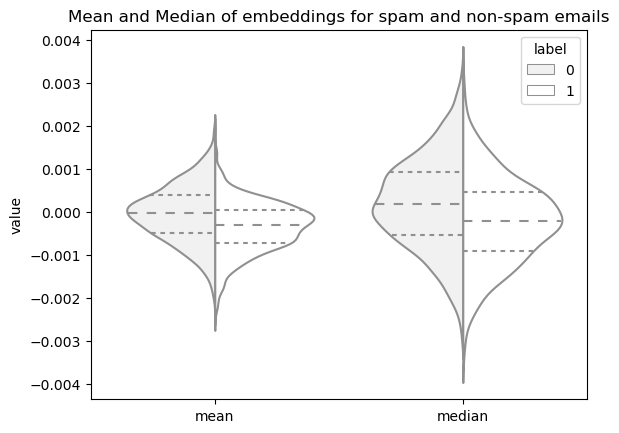

In [8]:
# create a violin plot
sns.violinplot(data=df_tmp, x='statistic', y='value', hue='label', fill=False, color='1', split=True, inner="quart" )
plt.xlabel('')
plt.title('Mean and Median of embeddings for spam and non-spam emails')
plt.show()


### 💡 Observations

The plot shows that the distribution of embedding vectors' averages is symmetric and centered around zero, no matter if the email is spam or not. However, the quartiles (dashed lines) for spam emails are slightly lower than for non-spam emails. This suggests that the embeddings can be used to distinguish between spam and non-spam emails. The same conclusion can be drawn from the distribution of median values of embeddings.

## PCA on embeddings

In the previous task, we collapsed the 786 dimensions of the embeddings into a single value by taking the mean or median. We can go a little further and create a more complex aggregation of the embeddings by using PCA. PCA is a dimensionality reduction technique that can be used to reduce the number of dimensions of a dataset while preserving as much variance as possible. Let's try it.

We take the following steps:

- Perform PCA on the embeddings to reduce the dimensionality of the data.
- Plot the explained variance ratio against the number of components.
- Plot the first two components of the PCA and color the points based on the email labels.

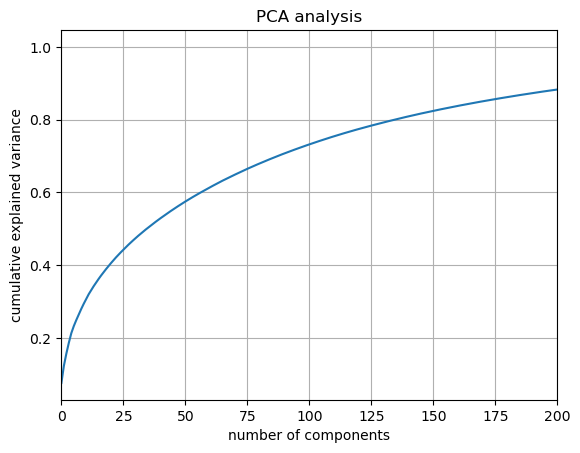

In [9]:
# perform PCA on embeddings to reduce the dimensionality of the data

pca = PCA(n_components=None)
pcs = pca.fit_transform(df.iloc[:, :-2])

# show the explained variance ratio versus the number of components

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA analysis')
plt.xlim(0, 200)
plt.grid()
plt.show()

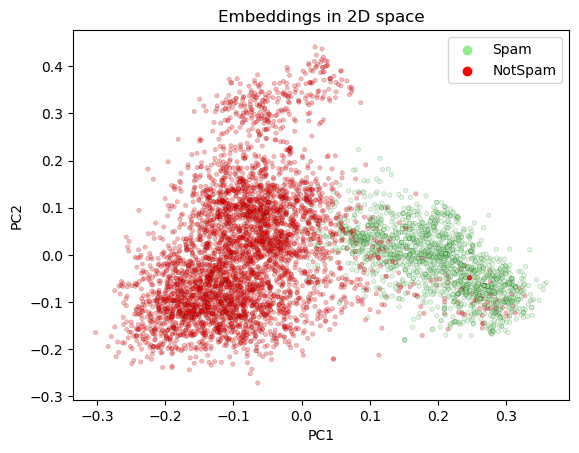

In [10]:
# plot the first two principal components and color the points by the label

label_mapping = {0: 'NotSpam', 1: 'Spam'}
mapped_labels = [label_mapping[label] for label in df['label']]

sns.scatterplot(x=pcs[:, 0], 
                y=pcs[:, 1], 
                hue=mapped_labels, 
                palette=['lightgreen', 'red'], edgecolor='k', alpha=0.3, s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Embeddings in 2D space')
plt.show()

### 💡 Observations

According to the first plot, the first two components can explain around 10% of the variance in the data which is not a lot. However, the second plot shows that spam and non-spam emails are somewhat separated by the first two components. Emails with similar semantic meaning are clustered together in the 2D space. This suggests that the embeddings can be used to distinguish between spam and non-spam emails. A simple classifier can probably leverage on this property and catch emails with spammish context from the rest.

## Build a spam detector

### Task 1 

Let's build a simple classifier to classify spam and non-spam emails. We will use the Logistic Regression classifier which is  a good starting point for text classification tasks.

- Split the data into training (70%) set and testing set (30%). Check the documentations [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- Train a Logistic Regression classifier on embeddings. Check the documentations [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 
- Evaluate the classifier on the train and test sets, and report the confusion matrix. Check the documentations [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). 

In [11]:
# import libraries


In [12]:
# split data into train and test sets


In [13]:
# train and evaluate the classifier and show the confusion matrix


### 💡 Observations

write your observation here

### Task 2

From the previous task you should have noticed that there is no sign of strong overfitting. However, the model might be too simple to capture the complexity of the data. The default regularization parameter C is set to 1.0 and may lead to underfitting. Therefore, we can still try to improve the classifier by tuning the regularization parameter. The regularization parameter controls the trade-off between fitting the training data well and keeping the model simple. To find the best value of the regularization parameter, we can use GridSearchCV, which also performs cross-validation. To avoid high computational cost, we can use PCA-transformed embeddings instead of the original embeddings. Let's train the model on the number of components that explain 90% of the variance in the data. This corresponds to about 200 components which is much less than the original 768 dimensions. To do this, we take the following steps:

- Perform PCA on the embeddings to reduce the dimensionality of the data. Set the parameter `n_components` to 0.90.
- Define a grid for the regularization parameter C. You can use a small range with 20 values in a log scale with `np.logspace(-1, 4, 20)`.
- Setup the `GridSearchCV` with the classifier, the grid, and 5 folds for cross-validation. Then train and tune the model. Check the documentations [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- Check the confusion matrix again.
- Plot the training and test accuracies versus C, spot the underfitting and overfitting regions, and find the best value of C.

In [14]:
# import libraries


In [15]:
# create a pipeline with PCA and Logistic Regression

# create a parameter grid

# train the model and tune hyperparameters C using GridSearchCV


In [16]:
# plotting train and test accuracy versus C 


In [17]:
# show confusion matrix on test data 


### 💡 Observations

write your observation here